In [25]:
import numpy as np
import cv2
import pickle
import glob

def calibrate_camera_still(calib_images,  grid_size = (9,6), imshow = True, delay = 500):

	""" Returns calibration parameters from calibration images

		Parameters
		----------
		calib_images : list of strings
			List of file paths as strings (e.g. glob.glob("/path/to/files/*.jpg").
		grid_size : tuple of int
			Size of calibration grid (internal corners)
		imshow : bool
			Show the calibration images
		delay : int, >=1
			Delay in msecs between each image for imshow
			
		Returns
		-------
		calib_params : dict
			Parameters for undistorting images.

	"""

	# termination criteria
	criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

	# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
	objp = np.zeros((grid_size[1]*grid_size[0],3), np.float32)
	objp[:,:2] = np.mgrid[0:grid_size[0],0:grid_size[1]].T.reshape(-1,2)

	# Arrays to store object points and image points from all the images.
	objpoints = [] # 3d point in real world space
	imgpoints = [] # 2d points in image plane.

	for filename in calib_images:
		img = cv2.imread(filename)

		if img != None:

			#img = cv2.resize(img, (0,0), None, fx = 0.25, fy = 0.25)
			gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

			# Find the chess board corners
			ret, corners = cv2.findChessboardCorners(gray, grid_size, None, flags = (cv2.CALIB_CB_ADAPTIVE_THRESH))
			#ret, corners = cv2.findCirclesGrid(gray, grid_size, None, flags = (cv2.CALIB_CB_ASYMMETRIC_GRID))
            
            # If found, add object points, image points (after refining them)
			if ret == True:
				objpoints.append(objp)
				corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
				imgpoints.append(corners2)

				if imshow == True:
					img = cv2.drawChessboardCorners(img, grid_size, corners, ret)

			# Draw and display the corners
			if imshow == True:
				cv2.imshow('img',img)
				cv2.waitKey(delay)
                
	if imshow == True:
		cv2.destroyAllWindows()
		for i in range(5):
			cv2.waitKey(1) 

	if len(objpoints) > 0 and len(imgpoints) > 0:
		ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
		calib_params = {"ret" : ret, "mtx" : mtx, "dist" : dist, "rvecs" : rvecs, "tvecs" : tvecs}
        
		total_error = 0
		for i in xrange(len(objpoints)):
			imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
			error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
			total_error += error 
		mean_error = total_error/len(objpoints)

		print "Calibration successful! Mean error: ", mean_error

	else:
		print "No calibration points found!"
		calib_params = None

	return calib_params


def undistort_image(image, calib_params, crop = True):

	""" Returns undistorted image using calibration parameters.

		Parameters
		----------
		image : numpy_array 
			Image to be undistorted
		calib_params : dict
			Calibration parameters from calibrate_camera()
		crop : bool
			Crop the image to the optimal region of interest
			
		Returns
		-------
		dst : numpy_array
			Undistorted image.

	"""
	try:
		ret = calib_params["ret"]
		mtx = calib_params["mtx"]
		dist = calib_params["dist"]
		rvecs = calib_params["rvecs"]
		tvecs = calib_params["tvecs"]
	except:
		raise TypeError("calib_params must be 'dict'")

	img = image
	h,  w = img.shape[:2]
	newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

	# undistort
	mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
	dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)


	# crop the image
	if crop:
		x,y,w,h = roi
		dst = dst[y:y+h, x:x+w]

	return dst
False
def save_calib(filename, calib_params): 
	""" Saves calibration parameters as '.pkl' file.

		Parameters
		----------
		filename : str
			Path to save file, must be '.pkl' extension
		calib_params : dict
			Calibration parameters to save

		Returns
		-------
		saved : bool
			Saved successfully.
	"""
	if type(calib_params) != dict:
			raise TypeError("calib_params must be 'dict'")

	output = open(filename, 'wb')

	try:
		pickle.dump(calib_params, output)
	except:
		raise IOError("filename must be '.pkl' extension")

	output.close()

	saved = True

	return saved

def load_calib(filename):
	""" Loads calibration parameters from '.pkl' file.

		Parameters
		----------
		filename : str8
			Path to load file, must be '.pkl' extension
			
		Returns
		-------
		calib_params : dict
			Parameters for undistorting images.

	"""
	# read python dict back from the file
	
	pkl_file = open(filename, 'rb')

	try:
		calib_params = pickle.load(pkl_file)
	except:
		raise IOError("File must be '.pkl' extension")

	pkl_file.close()

	return calib_params

## Get images for calibration
Here we use glob to load images for calibrating the camera

In [26]:
images = glob.glob("/home/jake/Downloads/drive-download-20161101T122151Z/*.tiff") #checkerboard
#images = glob.glob("/home/jake/Downloads/drive-download-20161101T120658Z/*.tiff")

images

['/home/jake/Downloads/drive-download-20161101T122151Z/Image__2016-10-31__17-47-36.tiff',
 '/home/jake/Downloads/drive-download-20161101T122151Z/Image__2016-10-31__17-47-41.tiff',
 '/home/jake/Downloads/drive-download-20161101T122151Z/Image__2016-10-31__17-47-48.tiff',
 '/home/jake/Downloads/drive-download-20161101T122151Z/Image__2016-10-31__17-46-28.tiff',
 '/home/jake/Downloads/drive-download-20161101T122151Z/Image__2016-10-31__17-46-53.tiff',
 '/home/jake/Downloads/drive-download-20161101T122151Z/Image__2016-10-31__17-45-56.tiff',
 '/home/jake/Downloads/drive-download-20161101T122151Z/Image__2016-10-31__17-46-18.tiff',
 '/home/jake/Downloads/drive-download-20161101T122151Z/Image__2016-10-31__17-46-15.tiff',
 '/home/jake/Downloads/drive-download-20161101T122151Z/Image__2016-10-31__17-46-58.tiff',
 '/home/jake/Downloads/drive-download-20161101T122151Z/Image__2016-10-31__17-47-51.tiff',
 '/home/jake/Downloads/drive-download-20161101T122151Z/Image__2016-10-31__17-47-27.tiff',
 '/home/ja

In [31]:
calib_params = calibrate_camera_still(images[:10], delay = 1)
calib_params

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:42: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Calibration successful! Mean error:  0.105562345398


{'dist': array([[ -6.48515752e-01,   3.41380853e+00,   2.52911832e-03,
          -1.66323233e-03,  -2.25567763e+01]]),
 'mtx': array([[  4.69291042e+03,   0.00000000e+00,   1.01275006e+03],
        [  0.00000000e+00,   4.70322163e+03,   1.00010340e+03],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]]),
 'ret': 0.8157294106577807,
 'rvecs': [array([[-0.26509055],
         [-0.2668713 ],
         [-1.46564152]]), array([[-0.19565709],
         [ 0.22783486],
         [-1.56283318]]), array([[ 0.46507913],
         [-0.49179319],
         [-1.53331927]]), array([[-0.2315888 ],
         [-0.26166165],
         [-1.52113554]]), array([[ 0.29997364],
         [ 0.32722451],
         [-1.60061339]]), array([[ 0.3979213 ],
         [ 0.3161546 ],
         [-1.51823382]]), array([[-0.15275949],
         [ 0.22347948],
         [-1.54087867]]), array([[-0.09772386],
         [ 0.18238568],
         [-1.54010728]]), array([[-0.18122221],
         [ 0.32566083],
         [-1.532203

In [34]:
import matplotlib.pyplot as plt

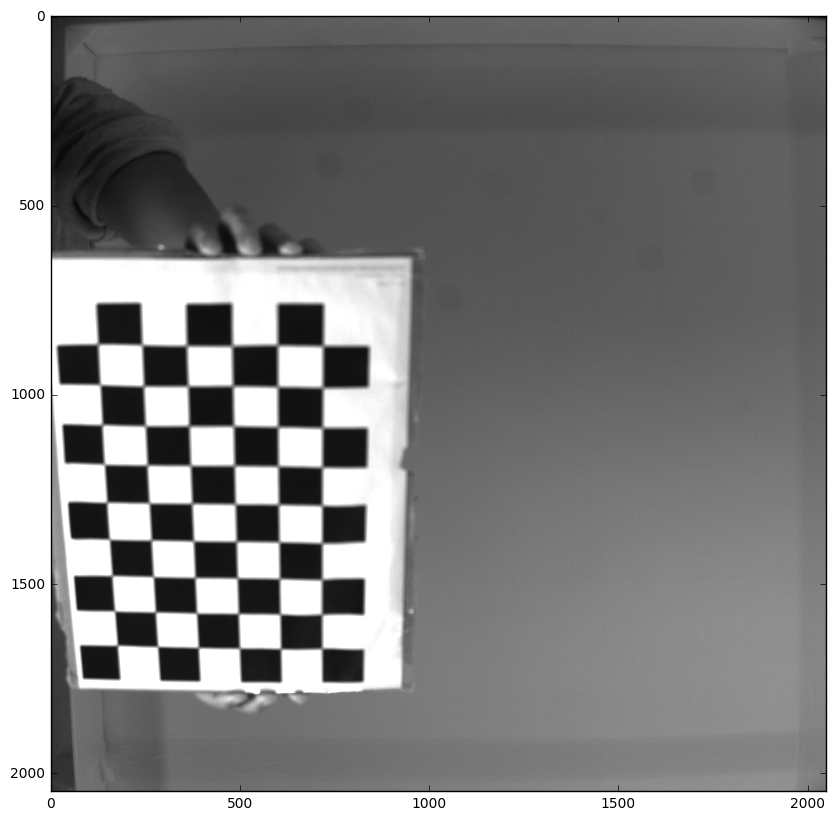

(1978, 1981, 3)


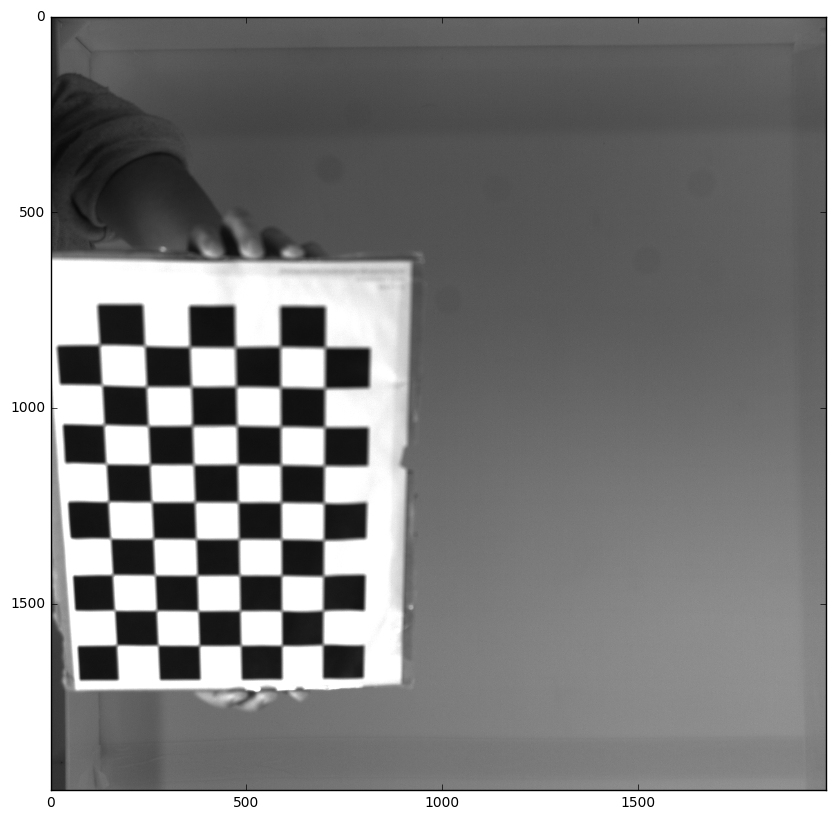

In [37]:
test_img = cv2.imread(images[5])
plt.figure(figsize = (10,10))
plt.imshow(test_img)
plt.show()
undistorted = undistort_image(test_img, calib_params, crop = True)
print undistorted.shape
plt.figure(figsize = (10,10))
plt.imshow(undistorted)
plt.show()